In [148]:
import pickle
import os, sys
import time
import numpy as np
from abbrrep_class import AbbrRep
import argparse
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from collections import Counter

import tensorflow as tf
import random
import fastText

import pandas as pd
import numpy as np
import scipy as sp
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import ast, pickle
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import os
from abbrrep_class import AbbrRep
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


FIGURE 1

In [122]:
def load_data(inputfile):

    pickle_in = open(inputfile, "rb")
    contents = pickle.load(pickle_in)
    pickle_in.close()
    
    return contents

In [123]:
def load_data2(inputfile):

    pickle_in = open(inputfile, "rb")
    contents = pickle.load(pickle_in)
    pickle_in.close()
    
    return contents

In [130]:
def get_word_id(word_samples):
    unique_word_id = {}
    current_id = 0
    
    for item in word_samples:
        if item not in unique_word_id:
            unique_word_id[item] = current_id
            current_id += 1
    return unique_word_id

In [124]:
def id2word(word_samples, word_dict):

    all_word_samples = []
    for sample_id in word_samples:
        word = ''
        for curr_id in range(1, len(sample_id)-1):
            if sample_id[curr_id] != 3 and sample_id[curr_id] != 2:
                word += word_dict[sample_id[curr_id]] + " "
        all_word_samples.append(word[:-1])
    
    all_word_samples_id = get_word_id(all_word_samples)
    
    return all_word_samples, all_word_samples_id

In [125]:
def shuffle_data(d):
    shuffled_d = {}
    for key in d:
        shuffled_d[key] = shuffle(d[key], random_state=42)
    return shuffled_d

In [126]:
def reduce_dimensions(method, X):
    # X = np.reshape(X, (len(X), -1))

    if method == "tsne":
        reduced_dim = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=42)
        results = reduced_dim.fit_transform(X)
    elif method == "pca":
        reduced_dim = PCA(n_components=2)
        results = reduced_dim.fit_transform(X)
        
    vis_x = results[:, 0]
    vis_y = results[:, 1]
    
    return vis_x, vis_y

In [127]:
def generate_text_box(label, lc):
    text_box = str(label)
    info_type = lc[0]
    j = 0
    words_per_line = 10
    text_box += '<br>{:s}'.format("L_LC:")
    if len(info_type) < words_per_line:
        text_box += '<br>{:s}'.format(str(info_type))
    else:
        while j <= len(info_type)-words_per_line:
            start = j
            j += words_per_line
            end = min(j, len(info_type))
            text_box += '<br>{:s}'.format(str(info_type[start:end]))
    
    info_type = lc[1]
    j = 0
    text_box += '<br>{:s}'.format("R_LC:")
    if len(info_type) <= words_per_line:
        text_box += '<br>{:s}'.format(str(info_type))
    else:
        while j < len(info_type)-words_per_line:
            start = j
            j += words_per_line
            end = min(j, len(info_type))
            text_box += '<br>{:s}'.format(str(info_type[start:end]))
    return text_box

In [128]:
def make_plot2(train_file, type_to_plot, reduction_method, num_samples_to_plot, abbr, show_unlabelled=False):
    
    dir = "/Users/Marta/80k_abbreviations/allacronyms"
    m = open(os.path.join(dir, "allacronyms_meta2name_20190318.pickle"), 'rb')
    meta2name = pickle.load(m)
    m.close()
    
    obs_data = load_data(train_file)
    word_labels = []
    encodings = []
    lc = []
    
    for key in obs_data['mimic_rs']:
        for x in obs_data['mimic_rs'][key]:
            word_labels.append("mimic_rs " + str(x.label))
            encodings.append(x.embedding)
            lc.append(generate_text_box(x.label, [x.features_left, x.features_right]))
        
    for x in obs_data['mimic_abbr'][abbr]:
        #label = list(meta2name[abbr][x.label])[0]
        label = x.label
        word_labels.append("mimic_unlabelled " +str(label))
        encodings.append(x.embedding)
        lc.append(generate_text_box(x.label, [x.features_left, x.features_right]))


    for x in obs_data['casi_abbr']["in vitro fertilization"]:
        word_labels.append("casi in vitro fertilization")
        encodings.append(x.embedding)
        lc.append(generate_text_box("casi_invitrofert", [x.features_left, x.features_right]))
        
    for x in obs_data['casi_abbr']["intravenous fluid"]:
        word_labels.append("casi intravenous fluid")
        encodings.append(x.embedding)
        lc.append(generate_text_box("casi_invitrofert", [x.features_left, x.features_right]))

    num_samples = len(encodings)
    sense_encoding_dict = {}
    for i in range(num_samples):
        sample = encodings[i]
        context = lc[i]
        key = str(word_labels[i])
        try:
            sense_encoding_dict[key].append([sample, context])
        except KeyError:
            sense_encoding_dict[key] = [[sample, context]]

    word_labels_id = get_word_id(word_labels)
    shuffled_sense_encoding_dict = shuffle_data(sense_encoding_dict)
    
    X_data = []
    y_data = []
    textbox = []

    total_count = 0
    for key in shuffled_sense_encoding_dict:
        num_samples = min(num_samples_to_plot, len(shuffled_sense_encoding_dict[key]))
        for i in range(num_samples):
            textbox.append(shuffled_sense_encoding_dict[key][i][1])
            X_data.append(shuffled_sense_encoding_dict[key][i][0])
            y_data.append(key)
        total_count += num_samples


    X_data_embeddings = np.zeros((total_count, 200))
    for i in range(len(X_data)):
        try:
            X_data_embeddings[i][:] = X_data[i]
        except:
            pass
    

    x_plot, y_plot = reduce_dimensions(reduction_method, X_data_embeddings)
    
    colour_list = []
    for word in y_data:
        colour_list.append(word_labels_id[word])
        
        
    data_dict = {}
    
    num_samples = len(y_data)
    print(num_samples)
    for i in range(num_samples):
        try:
            data_dict[y_data[i]][0].append(x_plot[i])
            data_dict[y_data[i]][1].append(y_plot[i])
            data_dict[y_data[i]][2].append(textbox[i])
        except KeyError:
            data_dict[y_data[i]] = [[x_plot[i]], [y_plot[i]], [textbox[i]]]
            
    plot_data = []
    N= len(word_labels_id)+1
    c= ['hsl('+str(h)+',100%'+',50%)' for h in np.linspace(0, 360, N)]
    #c.append('hsl(0,0%,0%)')
    #c.append('hsl(50,100%,100%)')
    counter = -1
    
    for key in data_dict:
        counter +=1
        if show_unlabelled == True:
            if key == "mimic_unlabelled intravenous fluid" or key == "mimic_unlabelled in vitro fertilization":
                c[counter] = 'hsl(0,0%,0%)'
                label = "unlabelled ivf"
            else:
                label = key
        else:
            label = key
        trace = go.Scatter(
            x = data_dict[key][0],
            y = data_dict[key][1],
            mode = 'markers',
            marker = dict(
                size = 10,
                color = c[counter],
                line = dict(width = 2, color = 'rgb(0, 0, 0)'),
                colorscale='Rainbow'
            ),
            text=data_dict[key][2],
            name=label
        )
        plot_data.append(trace)

    layout = go.Layout(
        dict(title = 'Aggregated Embeddings for ' + abbr,
             yaxis = dict(zeroline = False),
             xaxis = dict(zeroline = False)
            )
    )

    fig = dict(data=plot_data, layout=layout)
    return fig 

In [131]:
dest_dir = "/Volumes/terminator/hpf/abbr_dataset_mimic_casi_20190321_w5_ns500_LABELLED/CARD_master_150e/"
abbr = "dm" 
file = abbr + "_w5_ns500_LABELLED_CARD_MASTER150.pickle"
file = "ivf_dataset_rs_sim_LABELLEDABBR_casi_4.pickle"
dest_dir = "/Volumes/terminator/hpf/PhenoPad/200kabbreviations"
abbr = "ivf"

fig = make_plot2(os.path.join(dest_dir,file), 1, "tsne", 1000, abbr, show_unlabelled = True)
py.iplot(fig, filename='styled-scatter')

2575


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



TABLE 1: 

In [44]:
abbr_dict = ["ac", "asa", "av", "avr", "bal", "ca", "cea", "cvp", "dc", "dm", "dt", "er", "im", "ir", "ivf", "le",
            "op",  "otc", "pa", "pac", "pcp", "pda", "pe", "pr", "ra", "rt", "sbp", "sma"]

In [45]:
device = 'cpu'
import fastText
wordEmbed_model = os.path.join(os.path.abspath(os.path.join('./', os.pardir)), "word_embeddings.bin")
FASTTEXT_MODEL = fastText.load_model(wordEmbed_model)

In [46]:
class ConceptEmbedModel(nn.Module):
    def __init__(self, a, embedding_dim, pretrained_weight, ancestor_hierarchy, concepts):
        super().__init__()
        self.embed1 = nn.Embedding(a, embedding_dim)
        self.concepts = concepts
        self.embed1.weight.data.copy_(torch.from_numpy(pretrained_weight))
        self.ancestor_hierarchy = ancestor_hierarchy
        self.H = Variable(torch.randn(len(self.concepts), 200, dtype=torch.double) * 1e-9, requires_grad=False)

    def forward(self, x):
        local_H = torch.zeros(len(self.concepts), 200, dtype=torch.double, requires_grad=False)
        for i in range(len(self.concepts)):
            running_ancestor_embeds = self.embed1(torch.tensor(self.ancestor_hierarchy.rows[i]).to(device))
            running_ancestor_embeds_sum = running_ancestor_embeds.sum(0)
            local_H[i, :] = running_ancestor_embeds_sum

        concept_vector = torch.mm(local_H.to(device), torch.t(torch.tensor(x)).to(device))  # C * 200 x 200 * len(x)
        m = nn.Softmax(dim=1)
        x = torch.t(concept_vector)
        output = m(x)
        return output


In [47]:
def get_sparseMatrix(abbr):
    src_dir = "/Users/Marta/80k_abbreviations/create_samples/concept_embeddings/sparse_matrices_20190402"
    concept_matrix_file = abbr + "_umls_ancestor_sparseMatrix_20190402_full.pickle"
    p_in = open(os.path.join(src_dir, concept_matrix_file), 'rb')
    umls_rel = pickle.load(p_in)
    p_in.close()

    matrix_hierarchy = umls_rel["matrix_hierarchy"]
    word2idx = umls_rel["word2idx"]
    idx2word = umls_rel["idx2word"]
    all_ancetors = umls_rel["all_concepts"]

    return matrix_hierarchy, word2idx, idx2word, all_ancetors

In [58]:
def load_data(abbr):
    from sklearn.utils import shuffle
    import math

    root = "w5_ns1000_g_20190408"
    src_dir = "/Users/Marta/80k_abbreviations/abbr_dataset_mimic_casi" + root + "/"
    fname = abbr + "_mimic_casi_" + root + ".pickle"
    p_in = open(os.path.join(src_dir, fname), "rb")
    data = pickle.load(p_in)
    p_in.close()

    casi_data = data['casi_abbr']
    casi_test = []
    for subkey in casi_data:
        casi_test.extend(casi_data[subkey])
    casi_test = shuffle(casi_test, random_state=42)

    full_data = []
    for subkey in data["mimic_rs"]:
        curr_data = data["mimic_rs"][subkey]
        curr_data = shuffle(curr_data, random_state=42)
        full_data.extend(curr_data[:min(int(100), len(data["mimic_rs"][subkey]))])
    full_data = shuffle(full_data, random_state=42)
    split = math.floor(len(full_data) * 0.7)
    mimic_train = full_data[:split]
    mimic_test = full_data[split:]

    dir = "/Users/Marta/80k_abbreviations/allacronyms"
    n = open(os.path.join(dir, "allacronyms_cui2meta_20190402_NEW.pickle"), 'rb')
    cui2meta = pickle.load(n)
    n.close()

    m = open(os.path.join(dir, "allacronyms_meta2cui_20190402_NEW.pickle"), 'rb')
    meta2cui = pickle.load(m)
    m.close()

    o = open(os.path.join(dir, "allacronyms_meta2name_20190402_NEW.pickle"), 'rb')
    meta2name = pickle.load(o)
    o.close()

    q = open(os.path.join(dir, "allacronyms_name2meta_20190402_NEW.pickle"), 'rb')
    name2meta = pickle.load(q)
    q.close()


    return abbr, data, casi_test, mimic_test, mimic_train, cui2meta, meta2cui, meta2name, name2meta


In [49]:
def get_abbr_concepts(abbr, cui2meta, meta2namw):
    ancestor_hierarchy, word2idx, idx2word, all_ancestors = get_sparseMatrix(abbr)
    return ancestor_hierarchy, word2idx, idx2word, all_ancestors

In [55]:
def label_data(abbr):
    abbr, data, unlabelled_data, mimic_test, mimic_train, cui2meta, meta2cui, meta2name, name2meta = load_data(abbr)

    ancestor_hierarchy, word2idx, idx2word, all_ancestors = get_abbr_concepts(abbr, cui2meta, meta2name)
    concepts = word2idx
    pretrained_weight = np.zeros((len(concepts), 200))

    model = ConceptEmbedModel(len(concepts), 200, pretrained_weight, ancestor_hierarchy, concepts)
    src_dir = "/Volumes/terminator/hpf/20190322_modelcheckpoints/20190403_models_w5_g/"
    try:
        path = abbr + '_20190404_epoch50.pth.tar'
        model.load_state_dict(torch.load(src_dir+path, map_location='cpu'))
    except FileNotFoundError:
        path = abbr + '_20190405_epoch50.pth.tar'
        model.load_state_dict(torch.load(src_dir + path, map_location='cpu'))
    model.eval()

    score = 0
    total = 0

    for query in unlabelled_data:
        output = model(query.embedding)
        choices = list(cui2meta[abbr])
        choices_idx = []
        for i in choices:
            choices_idx.append(word2idx[i])
        loss = nn.Softmax()
        choices_idx = torch.tensor(choices_idx)

        values, indices = loss(output.squeeze()[choices_idx]).max(0)
        assigned_concept = idx2word[choices_idx[indices].item()]
        assigned_meta_id = cui2meta[abbr][assigned_concept]
        ground_truth = name2meta[abbr][query.label]
        if assigned_meta_id == ground_truth:
            score += 1

        total += 1
    print(abbr + " from " + "casi:" + '\t'+ "CORRECT=" + str(score) + '\t'+ " TOTAL=" + str(total))
    results["casi"][abbr] = [score, total]

    score = 0
    total = 0
    for query in mimic_test:
        output = model(query.embedding)
        choices = list(cui2meta[abbr])
        choices_idx = []
        for i in choices:
            choices_idx.append(word2idx[i])
        loss = nn.Softmax()
        choices_idx = torch.tensor(choices_idx)

        values, indices = loss(output.squeeze()[choices_idx]).max(0)
        assigned_concept = idx2word[choices_idx[indices].item()]
        assigned_meta_id = cui2meta[abbr][assigned_concept]
        ground_truth = name2meta[abbr][query.label]
        if assigned_meta_id == ground_truth:
            score += 1
        total += 1
    print(abbr + " from " + "mimic:" + '\t'+ "CORRECT=" + str(score) + '\t'+ " TOTAL=" + str(total))
    results["mimic"][abbr] = [score, total]

In [98]:
results = {}
results["mimic"] = {}
results["casi"] = {}
print("TABLE 1..............concept embedding model results, pretrained embeddings")
for abbr in abbr_dict:
    label_data(abbr)

micro_acc_casi = 0
total_casi = 0
score_casi = 0

micro_acc_mimic = 0
total_mimic = 0
score_mimic = 0

for abbr in results['casi']:
    correct = results['casi'][abbr][0]
    total = results['casi'][abbr][1]
    micro_acc_casi += correct/total
    total_casi += total
    score_casi += correct
micro_acc_casi /= len(results['casi'])
macro_acc_casi = score_casi/total_casi

for abbr in results['mimic']:
    correct = results['mimic'][abbr][0]
    total = results['mimic'][abbr][1]
    micro_acc_mimic += correct/total
    total_mimic += total
    score_mimic += correct
micro_acc_mimic /= len(results['mimic'])
macro_acc_mimic = score_mimic/total_mimic
print("\n")
print("**************************************")
print("\n")
print("MACRO ACC CASI:" + '\t'+ str(micro_acc_casi))
print("MICRO ACC CASI:" + '\t'+ str(macro_acc_casi))

print("MACRO ACC MIMIC:" + '\t'+ str(micro_acc_mimic))
print("MICRO ACC MIMIC:" + '\t'+ str(macro_acc_mimic))

print("Done labelling abbreviations with CEM using pretrained embeddings!!! \U0001F388 \U0001F33B")

TABLE 1..............concept embedding model results, pretrained embeddings


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ac from casi:	CORRECT=130	 TOTAL=162


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ac from mimic:	CORRECT=214	 TOTAL=497
asa from casi:	CORRECT=366	 TOTAL=493
asa from mimic:	CORRECT=106	 TOTAL=164
av from casi:	CORRECT=6	 TOTAL=8
av from mimic:	CORRECT=124	 TOTAL=211
avr from casi:	CORRECT=352	 TOTAL=359
avr from mimic:	CORRECT=30	 TOTAL=30
bal from casi:	CORRECT=429	 TOTAL=482
bal from mimic:	CORRECT=60	 TOTAL=77
ca from casi:	CORRECT=0	 TOTAL=490
ca from mimic:	CORRECT=168	 TOTAL=1130
cea from casi:	CORRECT=68	 TOTAL=493
cea from mimic:	CORRECT=52	 TOTAL=54
cvp from casi:	CORRECT=421	 TOTAL=421
cvp from mimic:	CORRECT=30	 TOTAL=30
dc from casi:	CORRECT=0	 TOTAL=454
dc from mimic:	CORRECT=131	 TOTAL=484
dm from casi:	CORRECT=103	 TOTAL=487
dm from mimic:	CORRECT=75	 TOTAL=322
dt from casi:	CORRECT=99	 TOTAL=114
dt from mimic:	CORRECT=116	 TOTAL=301
er from casi:	CORRECT=441	 TOTAL=480
er from mimic:	CORRECT=149	 TOTAL=218
im from casi:	CORRECT=110	 TOTAL=496
im from mimic:	CORRECT=151	 TOTAL=322
ir from casi:	CORRECT=2	 TOTAL=473
ir from mimic:	CORRECT=126	 TOTAL=2

In [99]:
def knn(abbr, data):
    X = []
    labels = []
    for item in data:
        X.append(item.embedding[0])
        labels.append(item.label)
    return X, labels

In [100]:
def get_NN(abbr, X, labels, query, name2meta, meta2name, num_neighbours=5):
    dist = np.linalg.norm((X - query), axis=1)
    x = dist.argsort()[:num_neighbours]
    poss_labels = []
    for i in x:
        poss_labels.append(labels[i])
    possible_ids = []
    for i in poss_labels:
        if i in meta2name[abbr]:
            possible_ids.append(i)
        else:
            possible_ids.append(name2meta[abbr][i])
    x = Counter(possible_ids)
    maj_vote = x.most_common()[0][0]
    return maj_vote

In [101]:
def label_data_knn(abbr, num_neighbours):
    abbr, data, unlabelled_data, mimic_test, mimic_train, cui2meta, meta2cui, meta2name, name2meta = load_data(abbr)
    ancestor_hierarchy, word2idx, idx2word, all_ancestors = get_abbr_concepts(abbr, cui2meta, meta2name)

    concepts = word2idx
    score = 0
    total = 0

    all_training_set, conept_labels = knn(abbr, mimic_train)

    for query in unlabelled_data:
        assigned_concept = get_NN(abbr, all_training_set, conept_labels, query.embedding, name2meta, meta2name, num_neighbours)
        try:
            assigned_meta_id = name2meta[abbr][assigned_concept]
        except KeyError:
            assigned_meta_id = assigned_concept
        ground_truth = name2meta[abbr][query.label]
        ground_truth_name = query.label
        if assigned_meta_id == ground_truth:
            score += 1
        total += 1
    print(abbr + " from " + "casi:" + '\t'+ "CORRECT=" + str(score) + '\t'+ " TOTAL=" + str(total))
    results["casi"][abbr] = [score, total]

    score = 0
    total = 0
    for query in mimic_test:
        assigned_concept = get_NN(abbr, all_training_set, conept_labels, query.embedding, name2meta, meta2name)

        assigned_meta_id = assigned_concept

        try:
            ground_truth = name2meta[abbr][query.label]
            ground_truth_name = query.label
        except KeyError:
            ground_truth = query.label
            ground_truth_name = meta2name[abbr][query.label]
       
        if assigned_meta_id == ground_truth:
            score += 1
        total += 1
    print(abbr + " from " + "mimic:" + '\t'+ "CORRECT=" + str(score) + '\t'+ " TOTAL=" + str(total))
    results["mimic"][abbr] = [score, total]

In [102]:
num_neighbours = 5
print("TABLE 1................................5-NN results, pretrained embeddings")

results = {}
results["mimic"] = {}
results["casi"] = {}

for abbr in abbr_dict:
    label_data_knn(abbr, num_neighbours)

micro_acc_casi = 0
total_casi = 0
score_casi = 0

micro_acc_mimic = 0
total_mimic = 0
score_mimic = 0

for abbr in results['casi']:
    correct = results['casi'][abbr][0]
    total = results['casi'][abbr][1]
    micro_acc_casi += correct/total
    total_casi += total
    score_casi += correct
micro_acc_casi /= len(results['casi'])
macro_acc_casi = score_casi/total_casi

for abbr in results['mimic']:
    correct = results['mimic'][abbr][0]
    total = results['mimic'][abbr][1]
    micro_acc_mimic += correct/total
    total_mimic += total
    score_mimic += correct
micro_acc_mimic /= len(results['mimic'])
macro_acc_mimic = score_mimic/total_mimic
print("\n")
print("**************************************")
print("\n")
print("MACRO ACC CASI:" + '\t'+ str(micro_acc_casi))
print("MICRO ACC CASI:" + '\t'+ str(macro_acc_casi))

print("MACRO ACC MIMIC:" + '\t'+ str(micro_acc_mimic))
print("MICRO ACC MIMIC:" + '\t'+ str(macro_acc_mimic))

print("Done labelling abbreviations with 5-NN using pretrained embeddings!!! \U0001F388 \U0001F33B")

TABLE 1................................5-NN results, pretrained embeddings
ac from casi:	CORRECT=115	 TOTAL=162
ac from mimic:	CORRECT=386	 TOTAL=497
asa from casi:	CORRECT=188	 TOTAL=493
asa from mimic:	CORRECT=130	 TOTAL=164
av from casi:	CORRECT=4	 TOTAL=8
av from mimic:	CORRECT=186	 TOTAL=211
avr from casi:	CORRECT=359	 TOTAL=359
avr from mimic:	CORRECT=30	 TOTAL=30
bal from casi:	CORRECT=431	 TOTAL=482
bal from mimic:	CORRECT=72	 TOTAL=77
ca from casi:	CORRECT=0	 TOTAL=490
ca from mimic:	CORRECT=753	 TOTAL=1130
cea from casi:	CORRECT=53	 TOTAL=493
cea from mimic:	CORRECT=50	 TOTAL=54
cvp from casi:	CORRECT=421	 TOTAL=421
cvp from mimic:	CORRECT=30	 TOTAL=30
dc from casi:	CORRECT=220	 TOTAL=454
dc from mimic:	CORRECT=348	 TOTAL=484
dm from casi:	CORRECT=310	 TOTAL=487
dm from mimic:	CORRECT=255	 TOTAL=322
dt from casi:	CORRECT=94	 TOTAL=114
dt from mimic:	CORRECT=223	 TOTAL=301
er from casi:	CORRECT=434	 TOTAL=480
er from mimic:	CORRECT=192	 TOTAL=218
im from casi:	CORRECT=41	 TOTA

FIGURE 3

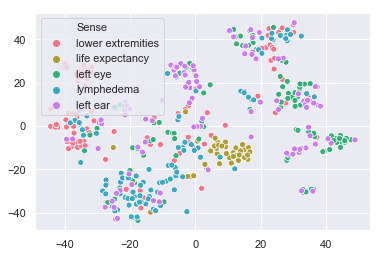

In [152]:
root = "w5_ns1000_g_20190408"
dest_dir = "/Users/Marta/80k_abbreviations/baselines/" 
file = "le_mimic_casi_" + root + ".pickle"
p_in = open(os.path.join(dest_dir, file), "rb")
data = pickle.load(p_in)
p_in.close()
X = []
labels = []
abbr = "le"
dir = "/Users/Marta/80k_abbreviations/allacronyms"
o = open(os.path.join(dir, "allacronyms_meta2name_20190402_NEW.pickle"), 'rb')
meta2name = pickle.load(o)
o.close()

colours =[]
for key in data["mimic_rs"]:
    if key not in meta2name[abbr]:
        continue
    temp = []

    if list(meta2name[abbr][key])[0] not in ['lower extremities', 'lymphedema', "life expectancy",
                                             "left ear", "left eye", "leukocyte esterase"]:
        continue
    for i in data["mimic_rs"][key]:
        temp.append(i.embedding[0])
    shuffle(temp)
    num_samples = min(len(temp), 100)
    for i in range(num_samples):
        X.append(temp[i])
        labels.append(list(meta2name[abbr][key])[0])



tsne = TSNE(n_components=2, verbose=0, perplexity=10, n_iter=1000, random_state=42)
results = tsne.fit_transform(X)


vis_x = results[:, 0]
vis_y = results[:, 1]


d = {'Sense': labels, 'Dataset': labels}
df = pd.DataFrame(data=d)
sns.scatterplot(x=vis_x, y=vis_y, hue=df["Sense"], palette="husl",legend="full")
plt.show()

TABLE 2

In [103]:
abbr_dict_50 = ["bmp", "cvp", "fsh", "mom","ac", "ald", "ama", "asa", "av", "avr", "bal", "bm",  "ca", "cea", "cr", "cva", "cvs", "dc", "dip",
     "dm", "dt", "er", "et", "gt", "im", "ir", "it", "ivf", "le",  "mp", "mr", "ms", "na", "np", "op",
     "or", "otc", "pa", "pac", "pcp", "pd", "pda", "pe", "pr", "pt", "ra", "rt", "sbp", "sma", "vad"]

In [104]:
class ConceptEmbedModel_Encoder():
    def phrase2vec(self, phrase_list, max_length):
        phrase_vec_list = []
        phrase_seq_lengths = []
        for phrase in phrase_list:
            start_left = int(max(len(phrase.features_left)-(max_length/2), 0))
            tokens = phrase.features_left[start_left:]
            end_right = int(min(len(phrase.features_right),(max_length/2)))
            tokens_right = phrase.features_left[:end_right]
            tokens.extend(tokens_right)
            phrase_vec_list.append([self.word_model.get_word_vector(tokens[i]) if i<len(tokens) else [0]*100 for i in range(max_length)])
            phrase_seq_lengths.append(len(tokens))
        return np.array(phrase_vec_list), np.array(phrase_seq_lengths)

    # ************** Initialize model ***************** #

    def __init__(self, abbr, sm, max_sequence_length, word_model):
        #print("Creating the model graph")
        tf.reset_default_graph()
        self.sm = sm
        self.word_model = word_model
        self.abbr = abbr
        concepts_size = len(self.sm['all_concepts']) +1
        self.cl1 = 1024
        self.cl2 = 1024
        

        # ************** Initialize matrix dimensions ***************** #
        self.label = tf.placeholder(tf.int32, shape=[None])
        self.class_weights = tf.Variable(tf.ones([concepts_size]), False)

        self.seq = tf.placeholder(tf.float32, shape=[None, max_sequence_length, 100])
        self.seq_len = tf.placeholder(tf.int32, shape=[None])
        self.lr = tf.Variable(0.002, trainable=False)
        self.is_training = tf.placeholder(tf.bool)


        # ************** Compute dense ancestor matrix from LIL matrix format ***************** #

        sparse_ancestrs = np.zeros((self.sm['matrix_hierarchy'].getnnz(), 2))
        counter = 0
        for row in range(self.sm['matrix_hierarchy'].shape[0]):
            for col in self.sm['matrix_hierarchy'].rows[row]:
                sparse_ancestrs[counter][0] = row
                sparse_ancestrs[counter][1] = col
                counter += 1

        self.ancestry_sparse_tensor = tf.sparse_reorder(tf.SparseTensor(indices=sparse_ancestrs, values=[1.0]*len(sparse_ancestrs),
                                                                        dense_shape=[concepts_size, concepts_size]))

        # ************** Encoder for sentence embeddings ***************** #

        layer1 = tf.layers.conv1d(self.seq, self.cl1, 1, activation=tf.nn.elu,\
                kernel_initializer=tf.random_normal_initializer(0.0,0.1),\
                bias_initializer=tf.random_normal_initializer(stddev=0.01), use_bias=True)

        layer2 = tf.layers.dense(tf.reduce_max(layer1, [1]), self.cl2, activation=tf.nn.relu,\
                kernel_initializer=tf.random_normal_initializer(0.0,stddev=0.1),
                bias_initializer=tf.random_normal_initializer(0.0,stddev=0.01), use_bias=True)

        self.seq_embedding = tf.nn.l2_normalize(layer2, axis=1)

        # ************** Concept embeddings ***************** #
        self.embeddings = tf.get_variable("embeddings", shape=[concepts_size, self.cl2],
                                          initializer=tf.random_normal_initializer(stddev=0.1))


        self.aggregated_embeddings = tf.sparse_tensor_dense_matmul(self.ancestry_sparse_tensor, self.embeddings)

        last_layer_b = tf.get_variable('last_layer_bias', shape = [concepts_size], initializer = tf.random_normal_initializer(stddev=0.001))

        self.score_layer = tf.matmul(self.seq_embedding, tf.transpose(self.aggregated_embeddings)) + last_layer_b

        # ************** Loss ***************** #
        self.loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(self.label, self.score_layer)) 
        self.pred = tf.nn.softmax(self.score_layer)
        self.agg_pred, _ =  tf.nn.top_k(tf.transpose(tf.sparse_tensor_dense_matmul(tf.sparse_transpose(self.ancestry_sparse_tensor), tf.transpose(self.pred))), 2)

        # ************** Backprop ***************** #
        self.train_step = tf.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
        self.sess.run(tf.global_variables_initializer())


    def load_params(self, repdir='.'):
        tf.train.Saver().restore(self.sess, (repdir+'.ckpt').replace('//','/'))


    def get_probs(self, val_samples):
        seq, seq_len = self.phrase2vec(val_samples, max_sequence_length)
        querry_dict = {self.seq: seq, self.seq_len: seq_len}
        res_querry = self.sess.run([self.pred, self.agg_pred], feed_dict=querry_dict)
        return res_querry

    def label_data(self, data, cui2meta, meta2name, name2meta, abbr, source):
        possible_expansions = list(cui2meta[abbr].keys())
        batch_size = 512
        head = 0
        while head < len(data):
            querry_subset = data[head:min(head + batch_size, len(data))]
            res_tmp, agg_pred_tmp = self.get_probs(querry_subset)
            if head == 0:
                res_querry = res_tmp  
                agg_pred = agg_pred_tmp  
            else:
                res_querry = np.concatenate((res_querry, res_tmp))
                agg_pred = np.concatenate((agg_pred, agg_pred_tmp))
            head += batch_size

        closest_concepts = []
        for s in range(len(data)):
            indecies_querry = np.argsort(-res_querry[s, :])
            tmp_res = []
            for i in indecies_querry:
                if i == len(self.sm['all_concepts']):
                    tmp_res.append(('None'))
                else:
                    tmp_res.append((self.sm['idx2word'][i], res_querry[s, i], agg_pred[s, 1]))

            closest_concepts.append(tmp_res)

        counter = 0
        score = 0
        total = 0
        for tmp_res in closest_concepts:
            seen = False
            for i in range(len(tmp_res)):
                if not seen and tmp_res[i][0] in possible_expansions:
                    label = cui2meta[abbr][tmp_res[i][0]]
                    ground_truth = name2meta[abbr][data[counter].label]
                    if label == ground_truth:
                        score +=1
                    break
            total += 1
            counter += 1
        print(abbr + " from " + source + ":" + '\t'+ "CORRECT="+ str(score) + '\t'+ " TOTAL=" + str(total))
        results[source][abbr] = [score, total]

In [105]:
def label_unlabelled_data(abbr, sm, max_sequence_length, param_dir, word_model):
    abbr, data, unlabelled_data, mimic_test, _, cui2meta, meta2cui, meta2name, name2meta = load_data(abbr)
    model = ConceptEmbedModel_Encoder(abbr, sm, max_sequence_length, word_model)
    model.load_params(repdir=param_dir)
    model.label_data(unlabelled_data, cui2meta, meta2name, name2meta, abbr, source="casi")
    model.label_data(mimic_test, cui2meta, meta2name, name2meta, abbr, source="mimic")

In [106]:

print("*****************************************************************************************************")
for dir_num in [100,500,1000]:
    for max_sequence_length in [6,10,16]:
        results = {}
        results["mimic"] = {}
        results["casi"] = {}
        print("TABLE 2................................concept embedding model results | samples:" 
              + str(dir_num) + " | max_sequence_length: " + str(max_sequence_length))
        word_model = fastText.load_model('../word_embeddings.bin')
        for abbr in abbr_dict_50:
            sm = "sparse_matrices_20190406/" + abbr + "_umls_ancestor_sparseMatrix_20190406_full.pickle"
            p_in = open(sm, 'rb')
            sm = pickle.load(p_in)
            p_in.close()
            param_dir = "/Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns" + str(dir_num) + "_w" + str(max_sequence_length)+"_20190408/tf_model_20190408_" +str(max_sequence_length) + "w_" + str(dir_num) + "S_"  + abbr + "/e49_params"

            label_unlabelled_data(abbr, sm, max_sequence_length, param_dir, word_model)

        micro_acc_casi = 0
        total_casi = 0
        score_casi = 0

        micro_acc_mimic = 0
        total_mimic = 0
        score_mimic = 0

        for abbr in results['casi']:
            correct = results['casi'][abbr][0]
            total = results['casi'][abbr][1]
            micro_acc_casi += correct/total
            total_casi += total
            score_casi += correct
        micro_acc_casi /= len(results['casi'])
        macro_acc_casi = score_casi/total_casi

        for abbr in results['mimic']:
            correct = results['mimic'][abbr][0]
            total = results['mimic'][abbr][1]
            micro_acc_mimic += correct/total
            total_mimic += total
            score_mimic += correct
        micro_acc_mimic /= len(results['mimic'])
        macro_acc_mimic = score_mimic/total_mimic

        print("\n")
        print("**************************************")
        print("\n")
        print("MACRO ACC CASI:" + '\t'+ str(micro_acc_casi))
        print("MICRO ACC CASI:" + '\t'+ str(macro_acc_casi))

        print("MACRO ACC MIMIC:" + '\t'+ str(micro_acc_mimic))
        print("MICRO ACC MIMIC:" + '\t'+ str(macro_acc_mimic))

        print("Done labelling abbreviations!!! \U0001F335 \U0001F33A")
        print("*****************************************************************************************************")

*****************************************************************************************************
TABLE 2................................concept embedding model results | samples:100 | max_sequence_length: 6
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w6_20190408/tf_model_20190408_6w_100S_bmp/e49_params.ckpt
bmp from casi:	CORRECT=0	 TOTAL=7
bmp from mimic:	CORRECT=15	 TOTAL=15
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w6_20190408/tf_model_20190408_6w_100S_cvp/e49_params.ckpt
cvp from casi:	CORRECT=421	 TOTAL=421
cvp from mimic:	CORRECT=30	 TOTAL=30
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w6_20190408/tf_model_20190408_6w_100S_fsh/e49_params.ckpt
fsh from casi:	CORRECT=260	 TOTAL=266
fsh from mimic:	CORRECT=3	 TOTAL=3
INFO:tensorflow:Restoring parameters from /Volu

na from casi:	CORRECT=65	 TOTAL=493
na from mimic:	CORRECT=240	 TOTAL=345
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w6_20190408/tf_model_20190408_6w_100S_np/e49_params.ckpt
np from casi:	CORRECT=78	 TOTAL=414
np from mimic:	CORRECT=399	 TOTAL=678
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w6_20190408/tf_model_20190408_6w_100S_op/e49_params.ckpt
op from casi:	CORRECT=211	 TOTAL=360
op from mimic:	CORRECT=176	 TOTAL=270
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w6_20190408/tf_model_20190408_6w_100S_or/e49_params.ckpt
or from casi:	CORRECT=231	 TOTAL=461
or from mimic:	CORRECT=111	 TOTAL=200
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w6_20190408/tf_model_20190408_6w_100S_otc/e49_params.ckpt
otc from 

INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w10_20190408/tf_model_20190408_10w_100S_cr/e49_params.ckpt
cr from casi:	CORRECT=287	 TOTAL=470
cr from mimic:	CORRECT=344	 TOTAL=516
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w10_20190408/tf_model_20190408_10w_100S_cva/e49_params.ckpt
cva from casi:	CORRECT=25	 TOTAL=270
cva from mimic:	CORRECT=64	 TOTAL=88
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w10_20190408/tf_model_20190408_10w_100S_cvs/e49_params.ckpt
cvs from casi:	CORRECT=30	 TOTAL=236
cvs from mimic:	CORRECT=50	 TOTAL=64
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w10_20190408/tf_model_20190408_10w_100S_dc/e49_params.ckpt
dc from casi:	CORRECT=43	 TOTAL=454
dc from mimic:	CORRECT=308	 TOTAL=484
I

rt from mimic:	CORRECT=336	 TOTAL=548
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w10_20190408/tf_model_20190408_10w_100S_sbp/e49_params.ckpt
sbp from casi:	CORRECT=303	 TOTAL=485
sbp from mimic:	CORRECT=47	 TOTAL=60
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w10_20190408/tf_model_20190408_10w_100S_sma/e49_params.ckpt
sma from casi:	CORRECT=102	 TOTAL=394
sma from mimic:	CORRECT=48	 TOTAL=73
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w10_20190408/tf_model_20190408_10w_100S_vad/e49_params.ckpt
vad from casi:	CORRECT=24	 TOTAL=95
vad from mimic:	CORRECT=59	 TOTAL=96


**************************************


MACRO ACC CASI:	0.3508404840551475
MICRO ACC CASI:	0.35444330949948927
MACRO ACC MIMIC:	0.7165254633693198
MICRO ACC MIMIC:	0.6430564362714014
Done labelling abbreviati

INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w16_20190408/tf_model_20190408_16w_100S_le/e49_params.ckpt
le from casi:	CORRECT=313	 TOTAL=471
le from mimic:	CORRECT=171	 TOTAL=271
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w16_20190408/tf_model_20190408_16w_100S_mp/e49_params.ckpt
mp from casi:	CORRECT=31	 TOTAL=100
mp from mimic:	CORRECT=358	 TOTAL=537
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w16_20190408/tf_model_20190408_16w_100S_mr/e49_params.ckpt
mr from casi:	CORRECT=201	 TOTAL=492
mr from mimic:	CORRECT=279	 TOTAL=400
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns100_w16_20190408/tf_model_20190408_16w_100S_ms/e49_params.ckpt
ms from casi:	CORRECT=18	 TOTAL=491
ms from mimic:	CORRECT=444	 TOTAL=672
IN

avr from casi:	CORRECT=250	 TOTAL=359
avr from mimic:	CORRECT=26	 TOTAL=30
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w6_20190408/tf_model_20190408_6w_500S_bal/e49_params.ckpt
bal from casi:	CORRECT=394	 TOTAL=482
bal from mimic:	CORRECT=69	 TOTAL=77
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w6_20190408/tf_model_20190408_6w_500S_bm/e49_params.ckpt
bm from casi:	CORRECT=257	 TOTAL=493
bm from mimic:	CORRECT=275	 TOTAL=348
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w6_20190408/tf_model_20190408_6w_500S_ca/e49_params.ckpt
ca from casi:	CORRECT=0	 TOTAL=490
ca from mimic:	CORRECT=882	 TOTAL=1130
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w6_20190408/tf_model_20190408_6w_500S_cea/e49_params.ckpt
cea fro

pe from mimic:	CORRECT=491	 TOTAL=609
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w6_20190408/tf_model_20190408_6w_500S_pr/e49_params.ckpt
pr from casi:	CORRECT=65	 TOTAL=241
pr from mimic:	CORRECT=747	 TOTAL=946
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w6_20190408/tf_model_20190408_6w_500S_pt/e49_params.ckpt
pt from casi:	CORRECT=189	 TOTAL=475
pt from mimic:	CORRECT=771	 TOTAL=1032
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w6_20190408/tf_model_20190408_6w_500S_ra/e49_params.ckpt
ra from casi:	CORRECT=62	 TOTAL=487
ra from mimic:	CORRECT=365	 TOTAL=469
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w6_20190408/tf_model_20190408_6w_500S_rt/e49_params.ckpt
rt from casi:	CORRECT=3	 TOTAL=151
rt from mim

INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w10_20190408/tf_model_20190408_10w_500S_im/e49_params.ckpt
im from casi:	CORRECT=58	 TOTAL=496
im from mimic:	CORRECT=238	 TOTAL=322
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w10_20190408/tf_model_20190408_10w_500S_ir/e49_params.ckpt
ir from casi:	CORRECT=297	 TOTAL=473
ir from mimic:	CORRECT=264	 TOTAL=293
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w10_20190408/tf_model_20190408_10w_500S_it/e49_params.ckpt
it from casi:	CORRECT=82	 TOTAL=222
it from mimic:	CORRECT=216	 TOTAL=245
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w10_20190408/tf_model_20190408_10w_500S_ivf/e49_params.ckpt
ivf from casi:	CORRECT=148	 TOTAL=476
ivf from mimic:	CORRECT=33	 TOTAL=34
I

ald from casi:	CORRECT=0	 TOTAL=86
ald from mimic:	CORRECT=81	 TOTAL=90
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w16_20190408/tf_model_20190408_16w_500S_ama/e49_params.ckpt
ama from casi:	CORRECT=42	 TOTAL=56
ama from mimic:	CORRECT=89	 TOTAL=92
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w16_20190408/tf_model_20190408_16w_500S_asa/e49_params.ckpt
asa from casi:	CORRECT=194	 TOTAL=493
asa from mimic:	CORRECT=140	 TOTAL=164
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w16_20190408/tf_model_20190408_16w_500S_av/e49_params.ckpt
av from casi:	CORRECT=3	 TOTAL=8
av from mimic:	CORRECT=189	 TOTAL=211
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w16_20190408/tf_model_20190408_16w_500S_avr/e49_params.ckpt
avr 

pac from casi:	CORRECT=138	 TOTAL=196
pac from mimic:	CORRECT=184	 TOTAL=226
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w16_20190408/tf_model_20190408_16w_500S_pcp/e49_params.ckpt
pcp from casi:	CORRECT=236	 TOTAL=490
pcp from mimic:	CORRECT=90	 TOTAL=94
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w16_20190408/tf_model_20190408_16w_500S_pd/e49_params.ckpt
pd from casi:	CORRECT=67	 TOTAL=412
pd from mimic:	CORRECT=537	 TOTAL=678
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w16_20190408/tf_model_20190408_16w_500S_pda/e49_params.ckpt
pda from casi:	CORRECT=322	 TOTAL=478
pda from mimic:	CORRECT=61	 TOTAL=64
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns500_w16_20190408/tf_model_20190408_16w_500S_pe/e49_params.ck

dm from mimic:	CORRECT=262	 TOTAL=322
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w6_20190408/tf_model_20190408_6w_1000S_dt/e49_params.ckpt
dt from casi:	CORRECT=52	 TOTAL=114
dt from mimic:	CORRECT=275	 TOTAL=301
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w6_20190408/tf_model_20190408_6w_1000S_er/e49_params.ckpt
er from casi:	CORRECT=348	 TOTAL=480
er from mimic:	CORRECT=204	 TOTAL=218
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w6_20190408/tf_model_20190408_6w_1000S_et/e49_params.ckpt
et from casi:	CORRECT=21	 TOTAL=199
et from mimic:	CORRECT=306	 TOTAL=369
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w6_20190408/tf_model_20190408_6w_1000S_gt/e49_params.ckpt
gt from casi:	CORRECT=41	 TOTAL=421
gt 

INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w10_20190408/tf_model_20190408_10w_1000S_cvp/e49_params.ckpt
cvp from casi:	CORRECT=421	 TOTAL=421
cvp from mimic:	CORRECT=30	 TOTAL=30
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w10_20190408/tf_model_20190408_10w_1000S_fsh/e49_params.ckpt
fsh from casi:	CORRECT=264	 TOTAL=266
fsh from mimic:	CORRECT=3	 TOTAL=3
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w10_20190408/tf_model_20190408_10w_1000S_mom/e49_params.ckpt
mom from casi:	CORRECT=57	 TOTAL=57
mom from mimic:	CORRECT=30	 TOTAL=30
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w10_20190408/tf_model_20190408_10w_1000S_ac/e49_params.ckpt
ac from casi:	CORRECT=85	 TOTAL=162
ac from mimic:	CORRECT=456	 TOTA

np from casi:	CORRECT=248	 TOTAL=414
np from mimic:	CORRECT=586	 TOTAL=678
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w10_20190408/tf_model_20190408_10w_1000S_op/e49_params.ckpt
op from casi:	CORRECT=311	 TOTAL=360
op from mimic:	CORRECT=230	 TOTAL=270
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w10_20190408/tf_model_20190408_10w_1000S_or/e49_params.ckpt
or from casi:	CORRECT=291	 TOTAL=461
or from mimic:	CORRECT=172	 TOTAL=200
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w10_20190408/tf_model_20190408_10w_1000S_otc/e49_params.ckpt
otc from casi:	CORRECT=397	 TOTAL=490
otc from mimic:	CORRECT=29	 TOTAL=30
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w10_20190408/tf_model_20190408_10w_1000S_pa/e49_par

cr from casi:	CORRECT=172	 TOTAL=470
cr from mimic:	CORRECT=462	 TOTAL=516
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w16_20190408/tf_model_20190408_16w_1000S_cva/e49_params.ckpt
cva from casi:	CORRECT=152	 TOTAL=270
cva from mimic:	CORRECT=83	 TOTAL=88
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w16_20190408/tf_model_20190408_16w_1000S_cvs/e49_params.ckpt
cvs from casi:	CORRECT=36	 TOTAL=236
cvs from mimic:	CORRECT=63	 TOTAL=64
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w16_20190408/tf_model_20190408_16w_1000S_dc/e49_params.ckpt
dc from casi:	CORRECT=72	 TOTAL=454
dc from mimic:	CORRECT=400	 TOTAL=484
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w16_20190408/tf_model_20190408_16w_1000S_dip/e49_par

sbp from casi:	CORRECT=306	 TOTAL=485
sbp from mimic:	CORRECT=55	 TOTAL=60
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w16_20190408/tf_model_20190408_16w_1000S_sma/e49_params.ckpt
sma from casi:	CORRECT=183	 TOTAL=394
sma from mimic:	CORRECT=53	 TOTAL=73
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190408_tf_modelcheckpoints/tf_model_indiv_ns1000_w16_20190408/tf_model_20190408_16w_1000S_vad/e49_params.ckpt
vad from casi:	CORRECT=26	 TOTAL=95
vad from mimic:	CORRECT=77	 TOTAL=96


**************************************


MACRO ACC CASI:	0.45640365143828826
MICRO ACC CASI:	0.46606514584042674
MACRO ACC MIMIC:	0.9019497942197531
MICRO ACC MIMIC:	0.8736207989854153
Done labelling abbreviations!!! 🌵 🌺
*****************************************************************************************************


TABLE 3

In [107]:
print("*****************************************************************************************************")
dir_num = 100
max_sequence_length = 10
results = {}
results["mimic"] = {}
results["casi"] = {}
print("TABLE 3................................MASTER MODEL RESULTS (one model for all abbrs) | samples:" 
      + str(dir_num) + " | max_sequence_length: " + str(max_sequence_length))
word_model = fastText.load_model('../word_embeddings.bin')
sm = "sparse_matrices_20190406/all_umls_ancestor_sparseMatrix_20190402_full.pickle"
p_in = open(sm, 'rb')
sm = pickle.load(p_in)
p_in.close()
param_dir = "/Volumes/terminator/hpf/20190406_tf_modelcheckpoints/master_tf_model_10w/e49_params"
for abbr in abbr_dict_50:
    label_unlabelled_data(abbr, sm, max_sequence_length, param_dir, word_model)

micro_acc_casi = 0
total_casi = 0
score_casi = 0

micro_acc_mimic = 0
total_mimic = 0
score_mimic = 0

for abbr in results['casi']:
    correct = results['casi'][abbr][0]
    total = results['casi'][abbr][1]
    micro_acc_casi += correct/total
    total_casi += total
    score_casi += correct
micro_acc_casi /= len(results['casi'])
macro_acc_casi = score_casi/total_casi

for abbr in results['mimic']:
    correct = results['mimic'][abbr][0]
    total = results['mimic'][abbr][1]
    micro_acc_mimic += correct/total
    total_mimic += total
    score_mimic += correct
micro_acc_mimic /= len(results['mimic'])
macro_acc_mimic = score_mimic/total_mimic

print("\n")
print("**************************************")
print("\n")
print("MACRO ACC CASI:" + '\t'+ str(micro_acc_casi))
print("MICRO ACC CASI:" + '\t'+ str(macro_acc_casi))

print("MACRO ACC MIMIC:" + '\t'+ str(micro_acc_mimic))
print("MICRO ACC MIMIC:" + '\t'+ str(macro_acc_mimic))

print("Done labelling abbreviations!!! \U0001F335 \U0001F33A")
print("*****************************************************************************************************")

*****************************************************************************************************
TABLE 3................................MASTER MODEL RESULTS (one model for all abbrs) | samples:100 | max_sequence_length: 10
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190406_tf_modelcheckpoints/master_tf_model_10w/e49_params.ckpt
bmp from casi:	CORRECT=1	 TOTAL=7
bmp from mimic:	CORRECT=14	 TOTAL=15
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190406_tf_modelcheckpoints/master_tf_model_10w/e49_params.ckpt
cvp from casi:	CORRECT=374	 TOTAL=421
cvp from mimic:	CORRECT=29	 TOTAL=30
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190406_tf_modelcheckpoints/master_tf_model_10w/e49_params.ckpt
fsh from casi:	CORRECT=231	 TOTAL=266
fsh from mimic:	CORRECT=3	 TOTAL=3
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190406_tf_modelcheckpoints/master_tf_model_10w/e49_params.ckpt
mom from casi:	CORRECT=55	 TO

pac from mimic:	CORRECT=160	 TOTAL=226
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190406_tf_modelcheckpoints/master_tf_model_10w/e49_params.ckpt
pcp from casi:	CORRECT=295	 TOTAL=490
pcp from mimic:	CORRECT=85	 TOTAL=94
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190406_tf_modelcheckpoints/master_tf_model_10w/e49_params.ckpt
pd from casi:	CORRECT=18	 TOTAL=412
pd from mimic:	CORRECT=419	 TOTAL=678
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190406_tf_modelcheckpoints/master_tf_model_10w/e49_params.ckpt
pda from casi:	CORRECT=197	 TOTAL=478
pda from mimic:	CORRECT=53	 TOTAL=64
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190406_tf_modelcheckpoints/master_tf_model_10w/e49_params.ckpt
pe from casi:	CORRECT=108	 TOTAL=382
pe from mimic:	CORRECT=390	 TOTAL=609
INFO:tensorflow:Restoring parameters from /Volumes/terminator/hpf/20190406_tf_modelcheckpoints/master_tf_model_10w/e49_params.ckpt
pr from

In [119]:
print("*****************************************************************************************************")
dir_num = 100
max_sequence_length = 16
results = {}
results["mimic"] = {}
results["casi"] = {}
print("TABLE 3................................MASTER MODEL RESULTS (one model for all abbrs) | samples:" 
      + str(dir_num) + " | max_sequence_length: " + str(max_sequence_length))
word_model = fastText.load_model('../word_embeddings.bin')
sm = "sparse_matrices_20190406/all_umls_ancestor_sparseMatrix_20190402_full.pickle"
p_in = open(sm, 'rb')
sm = pickle.load(p_in)
p_in.close()
param_dir = "/Volumes/terminator/hpf/20190406_tf_modelcheckpoints/master_tf_model_16w/e49_params"
for abbr in abbr_dict_50:
    label_unlabelled_data(abbr, sm, max_sequence_length, param_dir, word_model)

micro_acc_casi = 0
total_casi = 0
score_casi = 0

micro_acc_mimic = 0
total_mimic = 0
score_mimic = 0

for abbr in results['casi']:
    correct = results['casi'][abbr][0]
    total = results['casi'][abbr][1]
    micro_acc_casi += correct/total
    total_casi += total
    score_casi += correct
micro_acc_casi /= len(results['casi'])
macro_acc_casi = score_casi/total_casi

for abbr in results['mimic']:
    correct = results['mimic'][abbr][0]
    total = results['mimic'][abbr][1]
    micro_acc_mimic += correct/total
    total_mimic += total
    score_mimic += correct
micro_acc_mimic /= len(results['mimic'])
macro_acc_mimic = score_mimic/total_mimic

print("\n")
print("**************************************")
print("\n")
print("MACRO ACC CASI:" + '\t'+ str(micro_acc_casi))
print("MICRO ACC CASI:" + '\t'+ str(macro_acc_casi))

print("MACRO ACC MIMIC:" + '\t'+ str(micro_acc_mimic))
print("MICRO ACC MIMIC:" + '\t'+ str(macro_acc_mimic))

print("Done labelling abbreviations!!! \U0001F335 \U0001F33A")
print("*****************************************************************************************************")

#**********************NOTE: after rerunning results on the Jupyter notebook, I noticed 
# a mistake in the directories I specified to get the models from. As a results, the modeuls were incorrect.
# It takes 2 hours to output results per model, and I won't have time to do that before the deadline. As a result,
# I am catting the text files from when I originally ran the models not on Jupyter, which I had saved. If you
# want me to rerun the results in this Jupyter notebook, I'd be happy to do that. This is also applicable
# to the model underneath that I show results for

f = open("master_tf_model_16w_e49_20190408_50abbrs_output.txt")
for line in f:
    if "from casi" in line or "from mimic" in line or "ACC CASI:" in line or "ACC MIMIC:" in line:
        print(line)
    
print("Done labelling abbreviations!!! \U0001F335 \U0001F33A")
print("*****************************************************************************************************")


*****************************************************************************************************
TABLE 3................................MASTER MODEL RESULTS (one model for all abbrs) | samples:100 | max_sequence_length: 16
ac from casi: CORRECT=29 TOTAL=162

ac from mimic: CORRECT=1372 TOTAL=2307

ald from casi: CORRECT=0 TOTAL=86

ald from mimic: CORRECT=204 TOTAL=213

ama from casi: CORRECT=44 TOTAL=56

ama from mimic: CORRECT=97 TOTAL=107

asa from casi: CORRECT=74 TOTAL=493

asa from mimic: CORRECT=302 TOTAL=474

av from casi: CORRECT=0 TOTAL=8

av from mimic: CORRECT=459 TOTAL=592

avr from casi: CORRECT=197 TOTAL=359

avr from mimic: CORRECT=119 TOTAL=150

bal from casi: CORRECT=299 TOTAL=482

bal from mimic: CORRECT=235 TOTAL=304

bm from casi: CORRECT=61 TOTAL=493

bm from mimic: CORRECT=535 TOTAL=924

bmp from casi: CORRECT=1 TOTAL=7

bmp from mimic: CORRECT=15 TOTAL=15

ca from casi: CORRECT=0 TOTAL=490

ca from mimic: CORRECT=2105 TOTAL=3932

cea from casi: CORRECT=78 T

In [117]:
print("*****************************************************************************************************")
dir_num = 500
max_sequence_length = 10
results = {}
results["mimic"] = {}
results["casi"] = {}
print("TABLE 3................................MASTER MODEL RESULTS (one model for all abbrs) | samples:" 
      + str(dir_num) + " | max_sequence_length: " + str(max_sequence_length))
word_model = fastText.load_model('../word_embeddings.bin')
sm = "sparse_matrices_20190406/all_umls_ancestor_sparseMatrix_20190402_full.pickle"
p_in = open(sm, 'rb')
sm = pickle.load(p_in)
p_in.close()
param_dir = "/Volumes/terminator/hpf/tf_model_all_ns500_w10_20190408/e49_params"
for abbr in abbr_dict_50:
    label_unlabelled_data(abbr, sm, max_sequence_length, param_dir, word_model)

micro_acc_casi = 0
total_casi = 0
score_casi = 0

micro_acc_mimic = 0
total_mimic = 0
score_mimic = 0

for abbr in results['casi']:
    correct = results['casi'][abbr][0]
    total = results['casi'][abbr][1]
    micro_acc_casi += correct/total
    total_casi += total
    score_casi += correct
micro_acc_casi /= len(results['casi'])
macro_acc_casi = score_casi/total_casi

for abbr in results['mimic']:
    correct = results['mimic'][abbr][0]
    total = results['mimic'][abbr][1]
    micro_acc_mimic += correct/total
    total_mimic += total
    score_mimic += correct
micro_acc_mimic /= len(results['mimic'])
macro_acc_mimic = score_mimic/total_mimic

print("\n")
print("**************************************")
print("\n")
print("MACRO ACC CASI:" + '\t'+ str(micro_acc_casi))
print("MICRO ACC CASI:" + '\t'+ str(macro_acc_casi))

print("MACRO ACC MIMIC:" + '\t'+ str(micro_acc_mimic))
print("MICRO ACC MIMIC:" + '\t'+ str(macro_acc_mimic))

print("Done labelling abbreviations!!! \U0001F335 \U0001F33A")
print("*****************************************************************************************************")


#**********************NOTE: after rerunning results on the Jupyter notebook, I noticed 
# a mistake in the directories I specified to get the models from. As a results, the modeuls were incorrect.
# It takes 2 hours to output results per model, and I won't have time to do that before the deadline. As a result,
# I am catting the text files from when I originally ran the models not on Jupyter, which I had saved. If you
# want me to rerun the results in this Jupyter notebook, I'd be happy to do that. 

f = open("master_tf_model_500S_10w_e49_20190408_50abbrs_output.txt")
for line in f:
    if "from casi" in line or "from mimic" in line or "ACC CASI:" in line or "ACC MIMIC:" in line:
        print(line)
    
print("Done labelling abbreviations!!! \U0001F335 \U0001F33A")
print("*****************************************************************************************************")


*****************************************************************************************************
TABLE 3................................MASTER MODEL RESULTS (one model for all abbrs) | samples:500 | max_sequence_length: 10
bmp from casi: CORRECT=0 TOTAL=7

bmp from mimic: CORRECT=15 TOTAL=15

cvp from casi: CORRECT=420 TOTAL=421

cvp from mimic: CORRECT=150 TOTAL=150

fsh from casi: CORRECT=258 TOTAL=266

fsh from mimic: CORRECT=3 TOTAL=3

mom from casi: CORRECT=57 TOTAL=57

mom from mimic: CORRECT=150 TOTAL=150

ac from casi: CORRECT=75 TOTAL=162

ac from mimic: CORRECT=1821 TOTAL=2307

ald from casi: CORRECT=2 TOTAL=86

ald from mimic: CORRECT=207 TOTAL=213

ama from casi: CORRECT=46 TOTAL=56

ama from mimic: CORRECT=104 TOTAL=107

asa from casi: CORRECT=194 TOTAL=493

asa from mimic: CORRECT=367 TOTAL=474

av from casi: CORRECT=5 TOTAL=8

av from mimic: CORRECT=527 TOTAL=592

avr from casi: CORRECT=324 TOTAL=359

avr from mimic: CORRECT=145 TOTAL=150

bal from casi: CORRECT=382